#### About
> VAE
- Variational Autoencoder (VAE) is a type of artificial neural network used for unsupervised learning that can generate new data based on the input data. It is an extension of the basic autoencoder (AE) architecture that is used to learn a compressed representation of the input data.
- The key difference between VAEs and AEs is that VAEs are probabilistic models that learn the probability distribution of the input data, while AEs learn the deterministic mapping between the input and the output. VAEs also have an encoder-decoder architecture, but they are trained to optimize a lower bound on the likelihood of the data given a prior distribution, typically a Gaussian distribution, in the latent space. The resulting compressed representation is not only learned to be useful for reconstruction but also to generate new data points in the latent space.
- The main use case of VAEs is in generative modeling, where they can be used to generate new data points that are similar to the training data. This is particularly useful in domains where data is scarce, and it can be challenging to collect large amounts of labeled data for supervised learning.
- The KL divergence is often used as a regularization term in variational autoencoders (VAEs) to encourage the learned latent space to follow a specific prior distribution, typically a Gaussian distribution. In this case, the KL divergence measures the distance between the learned latent distribution and the desired prior distribution.
- Kullback-Leibler (KL) divergence is a measure of the difference between two probability distributions. It is often used in information theory and statistics to compare a model distribution to an actual distribution. KL divergence measures the amount of information lost when one distribution is used to approximate another distribution.
- The VAE architecture takes an input image, maps it to a lower-dimensional latent space, samples a latent variable from a learned distribution in that space, and then maps the sampled variable back to the original input space to generate a reconstructed image. The output of the VAE is not just the reconstructed image but also the mean and variance of the learned latent distribution, which are used to compute the KL divergence term in the loss function.


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

#### 1. Image Reconstruction.

> Architecture Description

1. The encoder is responsible for mapping the input image x to a lower-dimensional latent space representation z. In this architecture, the encoder is a feedforward neural network consisting of one fully connected layer with 400 hidden units followed by a rectified linear unit (ReLU) activation function. The output of this layer is split into two separate linear layers: the first one, fc21, outputs the mean of the latent distribution, while the second one, fc22, outputs the logarithm of the variance of the latent distribution.
2. The reparameterization module is responsible for sampling a latent variable z from the learned distribution represented by the mean and variance outputted by the encoder. In this architecture, the reparameterization module first computes the standard deviation of the latent distribution by exponentiating half of the logarithm of the variance outputted by the encoder. Then, it samples a latent variable z from a standard normal distribution and scales it by the computed standard deviation, adds the mean of the latent distribution, and returns the resulting z as the latent variable.
3. The decoder is responsible for mapping the latent variable z back to the original input space. In this architecture, the decoder is a feedforward neural network consisting of one fully connected layer with 400 hidden units followed by a ReLU activation function, and another fully connected layer with 784 units followed by a sigmoid activation function. The output of the second layer is the reconstructed image.

In [5]:
#VAE architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20) # mean
        self.fc22 = nn.Linear(400, 20) # variance
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1) # returns mean and variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) # returns sampled latent variable z

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)) # returns reconstructed image

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [6]:
# Define the loss function - BCE with regularisation
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [7]:

# Define the training loop
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

In [10]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [11]:
# Create the VAE and optimizer
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [13]:
# Train the VAE for several epochs
for epoch in range(1, 51):
    train(model, train_loader, optimizer, epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 113.789513
Train Epoch: 1 [12800/60000 (21%)]	Loss: 107.989738
Train Epoch: 1 [25600/60000 (43%)]	Loss: 103.629074
Train Epoch: 1 [38400/60000 (64%)]	Loss: 107.575668
Train Epoch: 1 [51200/60000 (85%)]	Loss: 107.880119
Train Epoch: 2 [0/60000 (0%)]	Loss: 106.521118
Train Epoch: 2 [12800/60000 (21%)]	Loss: 107.928642
Train Epoch: 2 [25600/60000 (43%)]	Loss: 104.636993
Train Epoch: 2 [38400/60000 (64%)]	Loss: 104.111397
Train Epoch: 2 [51200/60000 (85%)]	Loss: 108.849319
Train Epoch: 3 [0/60000 (0%)]	Loss: 105.204422
Train Epoch: 3 [12800/60000 (21%)]	Loss: 101.997269
Train Epoch: 3 [25600/60000 (43%)]	Loss: 105.190674
Train Epoch: 3 [38400/60000 (64%)]	Loss: 104.183670
Train Epoch: 3 [51200/60000 (85%)]	Loss: 107.010544
Train Epoch: 4 [0/60000 (0%)]	Loss: 107.345474
Train Epoch: 4 [12800/60000 (21%)]	Loss: 105.362755
Train Epoch: 4 [25600/60000 (43%)]	Loss: 107.639160
Train Epoch: 4 [38400/60000 (64%)]	Loss: 106.976318
Train Epoch: 4 [51200/60000 (85%

In [14]:
# Evaluating
transform = transforms.Compose([transforms.ToTensor()])
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

In [23]:
# assume that the trained VAE model is named 'vae_model'
# and the new dataset is loaded into a DataLoader named 'new_data_loader'

model.eval()
device = torch.device("cpu")
reconstruction_loss = nn.MSELoss(reduction='none')

total_loss = []
for batch_idx, (data, _) in enumerate(test_loader):
    data = data.to(device)
    recon_batch, mu, logvar = model(data)
    
    # compute reconstruction loss
    recon_loss =  loss_function(recon_batch, data, mu, logvar)
    

    loss = (recon_loss).item()
    total_loss.append(loss)

mean_loss = np.mean(total_loss)
std_loss = np.std(total_loss)

print("Mean loss: {:.3f}".format(mean_loss))
print("Standard deviation of loss: {:.3f}".format(std_loss))


Mean loss: 12893.700
Standard deviation of loss: 1305.604


In [26]:
# Evaluating on single image


model.eval()
image,_ = test_set.__getitem__(43)
with torch.no_grad():
    image = image.to(device)
    recon_image, mu, logvar = model(image.unsqueeze(0))
    
    # compute reconstruction loss
    
    recon_loss = loss_function(recon_batch, data, mu, logvar)

    
print("Total loss: {:.3f}".format(recon_loss))

Total loss: 1237.653


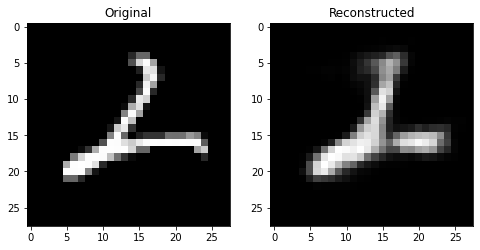

In [27]:
# convert the tensors to numpy arrays and reshape them into images
image = np.reshape(image.numpy(), (28, 28))
recon_image = np.reshape(recon_image.numpy(), (28, 28))

# display the original image and the reconstructed image side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original")
axes[1].imshow(recon_image, cmap='gray')
axes[1].set_title("Reconstructed")
plt.show()

#### 2. Image recognition.
- Image recognition is obtained by returning the probability using softmax layer

In [92]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 10)
        self.fc22 = nn.Linear(400, 10)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(128, 10)  # Classifier
        self.fc5 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc5(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        print(np.shape(mu), np.shape(logvar))
        z = self.reparameterize(mu, logvar)
        print(np.shape(self.fc4(z.T)))
        #recon_x = self.decode(z)
        class_probs = F.log_softmax(self.fc4(z), dim=1)
        return class_probs, mu, logvar


In [93]:
# define the loss function and optimizer
vae_model = VAE()
recon_loss = nn.BCELoss(reduction='sum') # for reconstrction
class_loss = nn.CrossEntropyLoss() # for classification loss
optimizer = optim.Adam(vae_model.parameters(), lr=0.001)


In [94]:
# train the VAE
vae_model.train()
for epoch in range(10):
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae_model(data)
        recon_loss_val = recon_loss(recon_batch, data.view(-1, 784))
        class_loss_val = class_loss(recon_batch, target)
        loss = recon_loss_val + class_loss_val
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

# evaluate the VAE
vae_model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        recon_batch, mu, logvar = vae_model(data)
        test_loss += recon_loss(recon_batch, data.view(-1, 784)).item()
        pred = recon_batch.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)
print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset), accuracy))

torch.Size([128, 10]) torch.Size([128, 10])
torch.Size([10, 10])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x10 and 128x10)